<a id="adversarial"></a>
## ML Project - Second Model Conditional DCGAN on MNIST DATASET

Quelques articles de recherches plus toward science pour aider:
- https://arxiv.org/pdf/1411.1784.pdf (Conditional Generative Adversarial Nets)
- https://arxiv.org/pdf/1406.2661.pdf (Generative Adversarial Nets)
- https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8

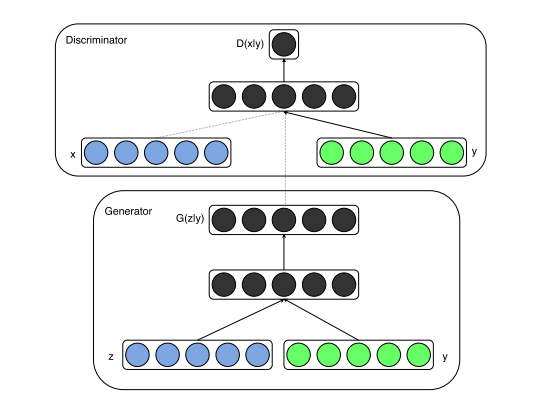

Ici l'objectif est d'ajouter une condition en entrée du générateur et du discriminateur. En l'occurrence pour nous, cette condition c'est les labels de mnist.  
Ce qui nous donne, en entrée du générateur un vecteur samplé d'une gaussienne, concaténé à un label encodé (en one-hot-encode, d'après l'article).  
Même chose pour le discriminateur, à la différence que celui prend en entrée une image, donc ça va changer l'encodage du label.  
MAIS dans l'idée ça revient au même.

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os
from helper_plot import hdr_plot_style
hdr_plot_style(font_size=12)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
batch_size = 32

# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [5]:
# Même architecture que pour le DCGAN, avec ajout de l'encodage des labels en entrée
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels + num_classes
        self.label_embedding = nn.Embedding(num_classes, 28*28*10) # Permet d'encoder les labels pour pouvoir les concaténer avec l'entrée du discriminateur... 
                                                                   # donc représentation des 10 classes dans des matrices de (28x28) dimensions 
                                                                   # (avec 28x28 correspondant à une image en entrée de discriminateur)
                                                                   # => Encodage des labels dans une matrice de dimensions 10x28x28
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
                   
            nn.Flatten(),
            nn.Linear(7*7*128, 1),
            # nn.Sigmoid() # Pas besoin si utilisation de nn.BCEWithLogitsLoss(), sinon nn.Sigmoid nécessaire
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 1, 28, 28)
        c = self.label_embedding(labels)
        c = c.view(x.size(0), 10, 28, 28)
        x = torch.cat([x, c], dim=1)
        output = self.model(x)
        return output

In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (label_embedding): Embedding(10, 7840)
  (model): Sequential(
    (0): Conv2d(11, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
  )
)


In [7]:
# Même architecture que pour le DCGAN, avec ajout de l'encodage des labels en entrée
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim + num_classes
        self.label_embedding = nn.Embedding(num_classes, 10) # Correspond à une autre représentation du one_hot_encode: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
                                                             # Permet d'encoder les labels de mnist dans un tenseur de 10 valeurs (matrice de 10x10 pour 10 classes
                                                             # => 0 = [1000000000])
                                                             # => 1 = [0100000000])
                                                             # ....
        self.fc = nn.Sequential(
          nn.Linear(input_dim, 7*7*256, bias=False),
          nn.BatchNorm1d(7*7*256),
          nn.LeakyReLU(0.2)
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh() # Tanh utile car les images du dataset sont normalisées entre [-1 ; 1].
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.fc(x)
        output = output.view(-1, 256, 7, 7)
        output = self.model(output)
        # output = output.view(-1, 1, 28, 28)
        return output

In [8]:
generator = Generator().to(device)
print(generator)

Generator(
  (label_embedding): Embedding(10, 10)
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [9]:
lr = 1e-4
num_epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

In [11]:
def train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path):

  if os.path.isfile(checkpoint_path):
    ckpt = torch.load(checkpoint_path)
    discriminator.load_state_dict(ckpt['discriminator'])
    generator.load_state_dict(ckpt['generator'])

    optimizer_discriminator.load_state_dict(ckpt['optimizer_disc'])
    optimizer_generator.load_state_dict(ckpt['optimizer_gen'])

    start_epoch = ckpt['epoch']
  
  else:
    start_epoch = 0


  for epoch in range(start_epoch, start_epoch + num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise, mnist_labels)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples, mnist_labels)
          disc_fake_output = discriminator(fake_samples.detach(), mnist_labels) # on detach fake_samples, car on n'a pas 
                                                                                # besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          disc_fake_output = discriminator(fake_samples, mnist_labels)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show losses
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              # Ajout du suivi de loss dans tensorboard afin d'avoir accès aux graphes de loss post-training 
              writer.add_scalar("Loss/Discriminator_train", loss_discriminator, epoch)
              writer.add_scalar("Loss/Generator_train", loss_generator, epoch)
              writer.flush()
              
              latent_space_samples = torch.randn(batch_size, 100).to(device)
              generated_samples = generator(latent_space_samples, mnist_labels)
              generated_samples = generated_samples.cpu().detach()

              # Plot de figure pendant l'entrainement, permet de vérifier le bon entrainement du GAN
              figure = plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  img = plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.title('label: ' + str(mnist_labels[i].cpu().detach().numpy()))
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()
              
              # Ajout de la figure dans tensorboard
              writer.add_figure('4_mnist_images', figure, epoch)
              writer.flush()

              # Save checkpoint (to prevent training problem)
              checkpoint = {
                  'epoch': epoch + 1,
                  'generator': generator.state_dict(),
                  'discriminator': discriminator.state_dict(),
                  'optimizer_gen': optimizer_generator.state_dict(),
                  'optimizer_disc': optimizer_discriminator.state_dict()
              }
              torch.save(checkpoint, checkpoint_path)

In [18]:
writer = SummaryWriter('runs/mnist_conditional_gan_exp1')

Epoch: 50 Loss D.: 0.6416171193122864
Epoch: 50 Loss G.: 0.7679710388183594


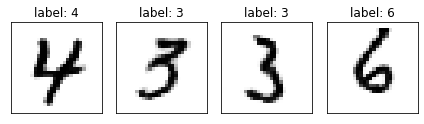

Epoch: 51 Loss D.: 0.6671047806739807
Epoch: 51 Loss G.: 0.836453914642334


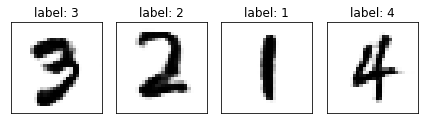

Epoch: 52 Loss D.: 0.6657112836837769
Epoch: 52 Loss G.: 0.7498290538787842


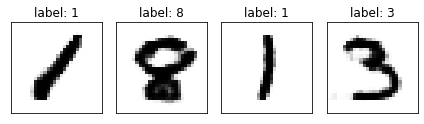

Epoch: 53 Loss D.: 0.6470871567726135
Epoch: 53 Loss G.: 0.69618821144104


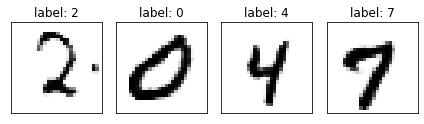

Epoch: 54 Loss D.: 0.6620689630508423
Epoch: 54 Loss G.: 0.7311750054359436


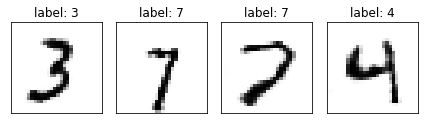

Epoch: 55 Loss D.: 0.6346816420555115
Epoch: 55 Loss G.: 0.7481858730316162


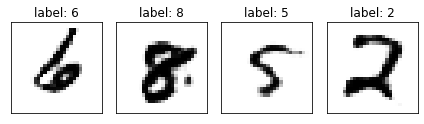

Epoch: 56 Loss D.: 0.6920770406723022
Epoch: 56 Loss G.: 0.7140012383460999


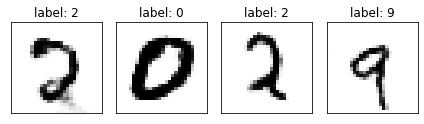

Epoch: 57 Loss D.: 0.6823195219039917
Epoch: 57 Loss G.: 0.7775979042053223


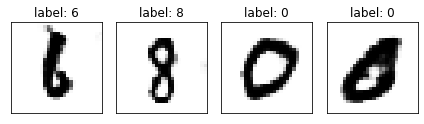

Epoch: 58 Loss D.: 0.672021746635437
Epoch: 58 Loss G.: 0.7468199729919434


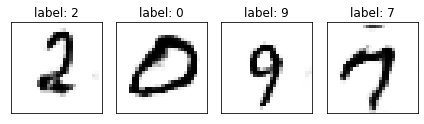

Epoch: 59 Loss D.: 0.6860017776489258
Epoch: 59 Loss G.: 0.7970807552337646


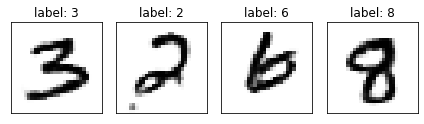

Epoch: 60 Loss D.: 0.7153671979904175
Epoch: 60 Loss G.: 0.7368296980857849


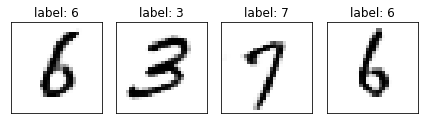

Epoch: 61 Loss D.: 0.6943793296813965
Epoch: 61 Loss G.: 0.7936279773712158


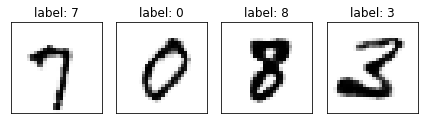

Epoch: 62 Loss D.: 0.6713398694992065
Epoch: 62 Loss G.: 0.74275803565979


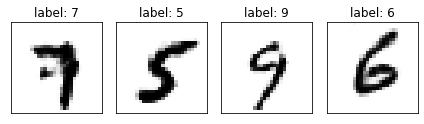

Epoch: 63 Loss D.: 0.6693010330200195
Epoch: 63 Loss G.: 0.7400087118148804


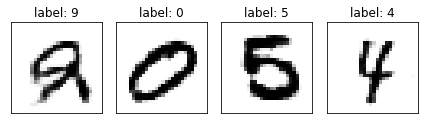

Epoch: 64 Loss D.: 0.6840129494667053
Epoch: 64 Loss G.: 0.7674424052238464


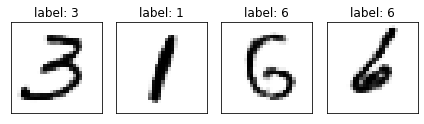

Epoch: 65 Loss D.: 0.6666582822799683
Epoch: 65 Loss G.: 0.7546629309654236


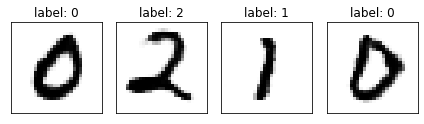

Epoch: 66 Loss D.: 0.6700600385665894
Epoch: 66 Loss G.: 0.933113694190979


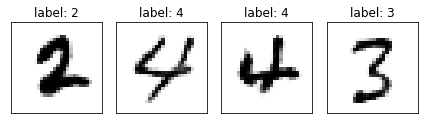

Epoch: 67 Loss D.: 0.6510082483291626
Epoch: 67 Loss G.: 0.721958339214325


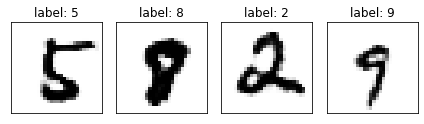

Epoch: 68 Loss D.: 0.6955390572547913
Epoch: 68 Loss G.: 0.6874909400939941


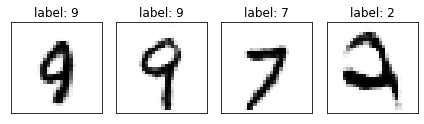

Epoch: 69 Loss D.: 0.7023597359657288
Epoch: 69 Loss G.: 0.7285130023956299


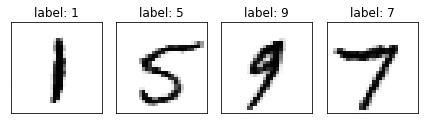

Epoch: 70 Loss D.: 0.6693116426467896
Epoch: 70 Loss G.: 0.723904550075531


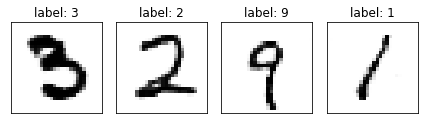

Epoch: 71 Loss D.: 0.673309862613678
Epoch: 71 Loss G.: 0.7205696105957031


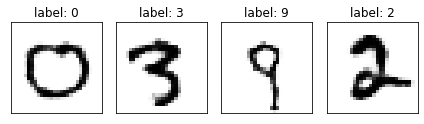

Epoch: 72 Loss D.: 0.7010005712509155
Epoch: 72 Loss G.: 0.8418600559234619


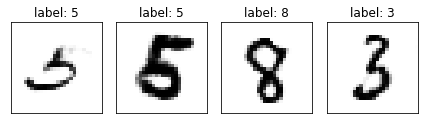

Epoch: 73 Loss D.: 0.711682140827179
Epoch: 73 Loss G.: 0.7681572437286377


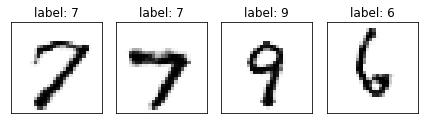

Epoch: 74 Loss D.: 0.6543469429016113
Epoch: 74 Loss G.: 0.7217411994934082


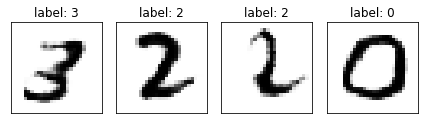

Epoch: 75 Loss D.: 0.6296647191047668
Epoch: 75 Loss G.: 0.7161033153533936


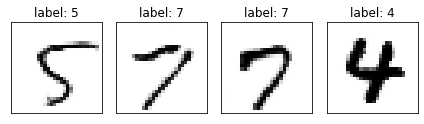

Epoch: 76 Loss D.: 0.6725102066993713
Epoch: 76 Loss G.: 0.8054941296577454


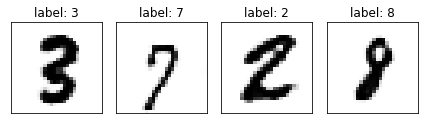

Epoch: 77 Loss D.: 0.7491449117660522
Epoch: 77 Loss G.: 0.719045877456665


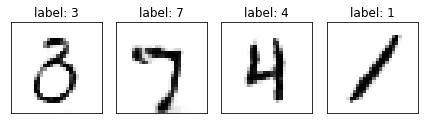

Epoch: 78 Loss D.: 0.6654266119003296
Epoch: 78 Loss G.: 0.7560307383537292


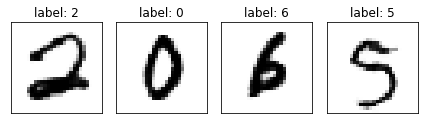

Epoch: 79 Loss D.: 0.6664083003997803
Epoch: 79 Loss G.: 0.8223897218704224


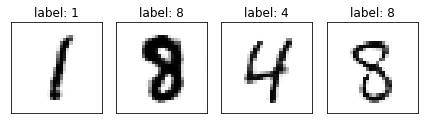

Epoch: 80 Loss D.: 0.6735331416130066
Epoch: 80 Loss G.: 0.7779093384742737


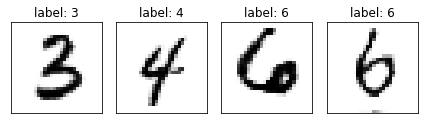

Epoch: 81 Loss D.: 0.6469655632972717
Epoch: 81 Loss G.: 0.7557339072227478


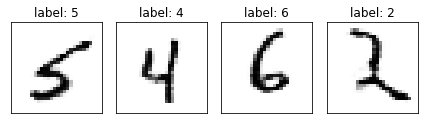

Epoch: 82 Loss D.: 0.6930689811706543
Epoch: 82 Loss G.: 0.7917507290840149


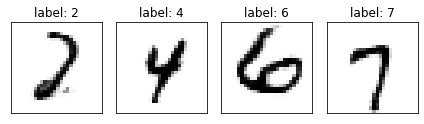

Epoch: 83 Loss D.: 0.6596730947494507
Epoch: 83 Loss G.: 0.7957777976989746


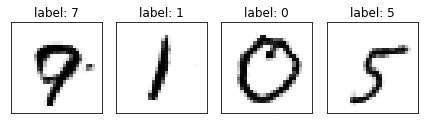

Epoch: 84 Loss D.: 0.6820094585418701
Epoch: 84 Loss G.: 0.8266134262084961


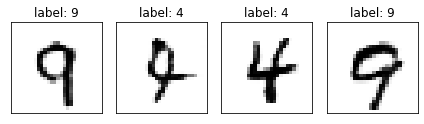

Epoch: 85 Loss D.: 0.6556154489517212
Epoch: 85 Loss G.: 0.8228373527526855


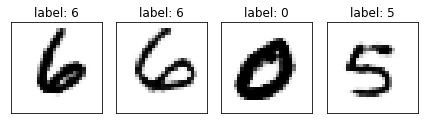

Epoch: 86 Loss D.: 0.7079631686210632
Epoch: 86 Loss G.: 0.7595124244689941


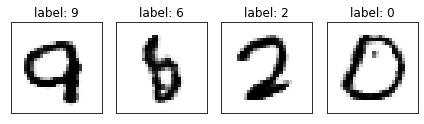

Epoch: 87 Loss D.: 0.6394602060317993
Epoch: 87 Loss G.: 0.7990180253982544


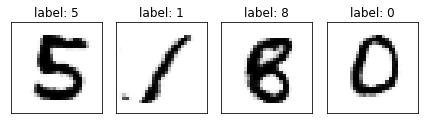

Epoch: 88 Loss D.: 0.6887063980102539
Epoch: 88 Loss G.: 0.8168836236000061


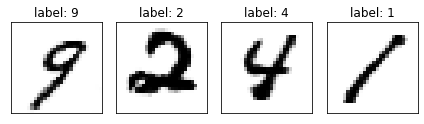

Epoch: 89 Loss D.: 0.6573095321655273
Epoch: 89 Loss G.: 0.8851849436759949


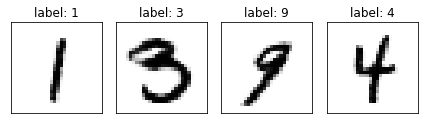

Epoch: 90 Loss D.: 0.6817115545272827
Epoch: 90 Loss G.: 0.808403491973877


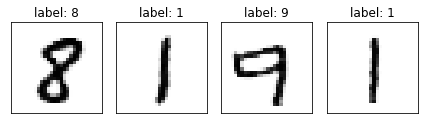

Epoch: 91 Loss D.: 0.6683478355407715
Epoch: 91 Loss G.: 0.856835663318634


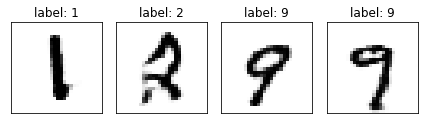

Epoch: 92 Loss D.: 0.6779288649559021
Epoch: 92 Loss G.: 0.8028052449226379


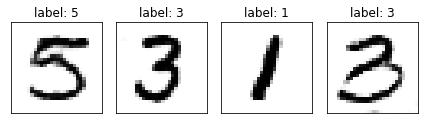

Epoch: 93 Loss D.: 0.6894016265869141
Epoch: 93 Loss G.: 0.7786861658096313


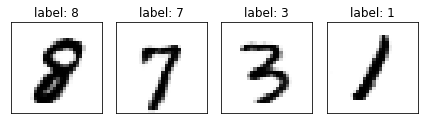

Epoch: 94 Loss D.: 0.6530585885047913
Epoch: 94 Loss G.: 0.8490321636199951


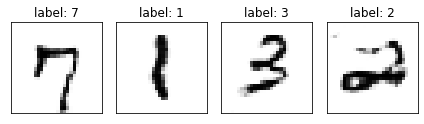

Epoch: 95 Loss D.: 0.6758542656898499
Epoch: 95 Loss G.: 0.7771077156066895


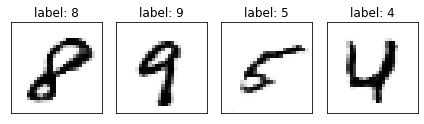

Epoch: 96 Loss D.: 0.6891071200370789
Epoch: 96 Loss G.: 0.7517317533493042


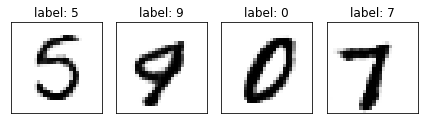

Epoch: 97 Loss D.: 0.6456137299537659
Epoch: 97 Loss G.: 0.7049160003662109


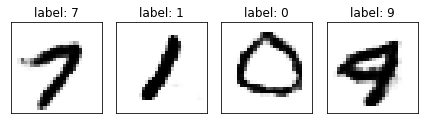

Epoch: 98 Loss D.: 0.6394000053405762
Epoch: 98 Loss G.: 0.8206585645675659


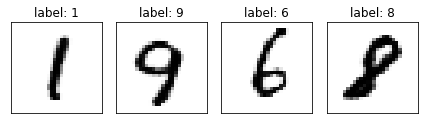

Epoch: 99 Loss D.: 0.6338896751403809
Epoch: 99 Loss G.: 0.8603377938270569


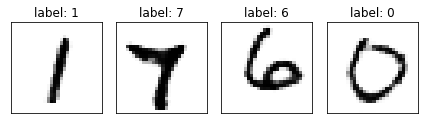

In [19]:
# Lance la boucle de training, si un checkpoint est trouvé, alors continue le training, sinon en démarre un nouveau
train(train_loader, num_epochs, discriminator, generator, optimizer_generator, optimizer_discriminator, checkpoint_path='../trained_model/mnist_conditional_gan_100epo.pt')

### Test du CGAN

In [13]:
ckpt_path = '../trained_model/mnist_conditional_gan_100epo.pt'

In [14]:
if os.path.isfile(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
    discriminator.load_state_dict(ckpt['discriminator'])
    generator.load_state_dict(ckpt['generator'])

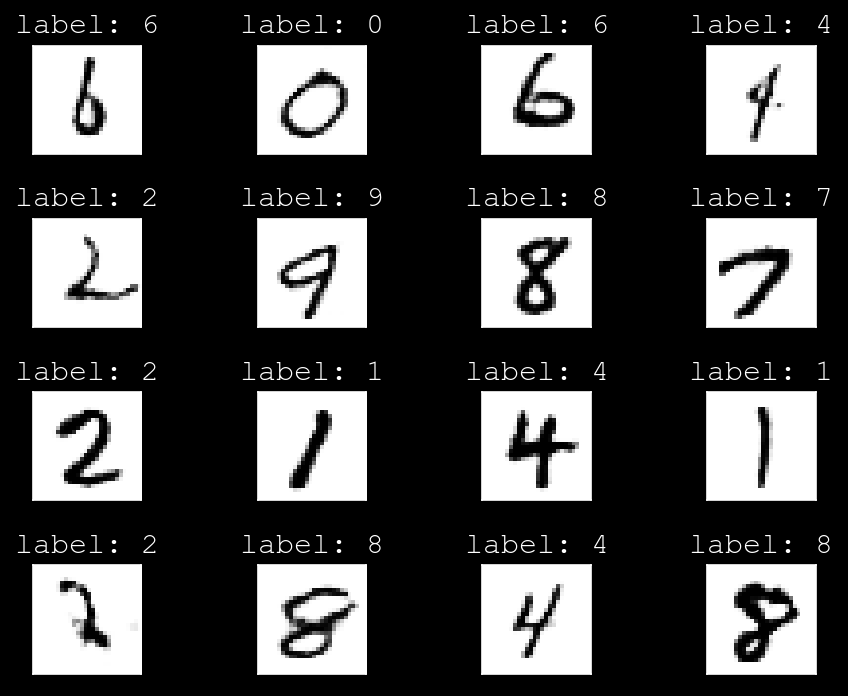

In [15]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
labels = torch.randint(0, 10, size=(32,))

generated_samples = generator(latent_space_samples, labels)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.title('label: ' + str(labels[i].numpy()))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()